---
# <font color='blue'> Case Study 6 </font>


## <font color='blue'>Group</font>
* Helene Barrera
* Sam Vonpaays Soh
* Justin Ehly

In [1]:
#To run with google colab, add data to your google drive
#Then mount the drive by running the below code and entering your authorization code when the window pops up
#Lastly, click the folder on the left sidebar, and locate your data under 'drive' <- MyDrive ect
#You can right click your data to get the path and paste it in cell 4.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# update pandas-profiling in colab
# how to run pandas profiling in google colab
# https://python.plainenglish.io/how-to-use-pandas-profiling-on-google-colab-e34f34ff1c9f
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


## <font color='blue'>Business Understanding (5pts)</font>
<br>
The goal of this case is to build a dense neural network that accurately predicts the detection of new particles. This is a binary classification problem that will be modeled using labratory data provided from a research client. Due to the complexity and size of the data, the lack of a data dictonary, and the client's emphasis on accuracy, for this study the approach will be less interpretable and more focused on accurate predictions (in other word the client dosn't need to know how it works, just that it gives reliable, actionable results). The data analytics team will use accuracy as the primary measure to determine proper model performance with precision and recall as back up to ensure that appropriate model fit does not under represent the minority class.

## <font color='blue'>Data Evaluation/ Engineering (10pts)</font>

### Section Summary</font>
<br>
The dataset is enormous, consisting of 7 million rows and 29 columns. Because of this, initially a small sample of 1% (70,000 rows) will be used to build the model and the full dataset will be used to check that the model is applicable on the it. There are no null values, although it's possible that a number represents a null value. Without a data dictonary or futher clarification we cannot say, so we will assume no missing values. Using a correlation matrix, we determined that while there was some colinearity, it was not enough to justify removing any of the variables, especially since we don't fully know what they represent. Variables f0, f3, f5, f6, f10, f14, f18, f23, f24, f26 all exhibit skewed distributions, so scaling should be utilized to account for that. Interestingly, the mass variable only has 5 different values. 
It is also important to note that the target variable is split evenly between the two classifications (detected vs not detected).  


In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import time

In [4]:
%%time
# read in all data 
#init_df = pd.read_csv('/content/drive/MyDrive/_SMU/7333 - Quantifying the World/Case Study 6/all_train.csv.gz') # read_csv has a native reader for .gz files with default set to 'infer' for the file type
init_df = pd.read_csv('/content/drive/MyDrive/Data_Science/all_train.csv.gz')

init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000000 entries, 0 to 6999999
Data columns (total 29 columns):
 #   Column   Dtype  
---  ------   -----  
 0   # label  float64
 1   f0       float64
 2   f1       float64
 3   f2       float64
 4   f3       float64
 5   f4       float64
 6   f5       float64
 7   f6       float64
 8   f7       float64
 9   f8       float64
 10  f9       float64
 11  f10      float64
 12  f11      float64
 13  f12      float64
 14  f13      float64
 15  f14      float64
 16  f15      float64
 17  f16      float64
 18  f17      float64
 19  f18      float64
 20  f19      float64
 21  f20      float64
 22  f21      float64
 23  f22      float64
 24  f23      float64
 25  f24      float64
 26  f25      float64
 27  f26      float64
 28  mass     float64
dtypes: float64(29)
memory usage: 1.5 GB
CPU times: user 1min 16s, sys: 3.38 s, total: 1min 19s
Wall time: 1min 19s


In [5]:
init_df.describe().T

,count,mean,std,min,25%,50%,75%,max
# label,7000000.0,0.500126,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000
f0,7000000.0,0.016125,1.004417,-1.960549,-0.728821,-0.039303,0.690080,4.378282
f1,7000000.0,0.000477,0.997486,-2.365355,-0.733255,0.000852,0.734783,2.365287
f2,7000000.0,0.000027,1.000080,-1.732165,-0.865670,0.000320,0.865946,1.732370
f3,7000000.0,0.010561,0.995600,-9.980274,-0.609229,0.019633,0.679882,4.148023
f4,7000000.0,-0.000105,0.999867,-1.732137,-0.865802,-0.000507,0.865765,1.731978
f5,7000000.0,0.002766,1.000957,-1.054221,-1.054221,-0.005984,0.850488,4.482618
f6,7000000.0,0.018160,0.986775,-3.034787,-0.756609,-0.149953,0.768669,3.720345
f7,7000000.0,0.000025,0.996587,-2.757853,-0.701415,-0.000107,0.701319,2.758590
f8,7000000.0,0.000435,1.000007,-1.732359,-0.865654,0.001385,0.866598,1.731450


In [6]:
# subsample dataset: 1% sample = 70,000 rows of data ~ 16mb

DATA = init_df.sample(frac = 0.01, random_state = 42)
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 949791 to 2361794
Data columns (total 29 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   # label  70000 non-null  float64
 1   f0       70000 non-null  float64
 2   f1       70000 non-null  float64
 3   f2       70000 non-null  float64
 4   f3       70000 non-null  float64
 5   f4       70000 non-null  float64
 6   f5       70000 non-null  float64
 7   f6       70000 non-null  float64
 8   f7       70000 non-null  float64
 9   f8       70000 non-null  float64
 10  f9       70000 non-null  float64
 11  f10      70000 non-null  float64
 12  f11      70000 non-null  float64
 13  f12      70000 non-null  float64
 14  f13      70000 non-null  float64
 15  f14      70000 non-null  float64
 16  f15      70000 non-null  float64
 17  f16      70000 non-null  float64
 18  f17      70000 non-null  float64
 19  f18      70000 non-null  float64
 20  f19      70000 non-null  float64
 21  f20  

With the pandas profile report, we can quickly glance over the variables to check for anything that sticks out in the data. (see section summary at top of section for EDA/analysis).

In [7]:
%%time

from pandas_profiling import ProfileReport

profile = ProfileReport(init_df, minimal = True, title='Pandas Profiling Report for Cast Study 6')
#profile.to_file('CS6_data_profile_report.html')

CPU times: user 938 ms, sys: 255 ms, total: 1.19 s
Wall time: 1.9 s


In [8]:
%%time
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 42s, sys: 8.64 s, total: 1min 51s
Wall time: 1min 10s


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook 
%matplotlib inline

# helper function: look at correlation heatmap

def corr_map(data, xxx, yyy):
    corr = data.corr()
    matrix = np.triu(corr)


    f, ax = plt.subplots(figsize=(xxx,yyy))
    heatmap = sns.heatmap(corr, annot=False, mask=matrix, cmap='BrBG')
    heatmap.set_title('Correlation Columns', fontdict={'fontsize':18}, pad=16);
    plt.show()

########################################################################

# automating the process of removing highly correlated variables
# returns a list of features that are correlated above the percentage fed into the function

def auto_corr(data, corr_percentage):
    corr_matrix = data.corr().abs() #get the correlation matrix with absolute values

    # select just the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    #print(upper_tri) # view the columns

    # get columns with over 0.95 (95%) correlation

    #use list comprehension to get a list of ultra high correlated variables
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_percentage)] 

    # print list of variables to drop from dataframe
    corrs = len(to_drop)
    
    if corrs == 0:
        print('There are no variables correlated over %s' % corr_percentage)
    else: 
        print('\nThere are a total of %d variables to drop due to a correlation over %s' % (corrs, corr_percentage))
        print('\nThese are the variables that are correlated over %s:' % corr_percentage,to_drop)
    
    return to_drop
    

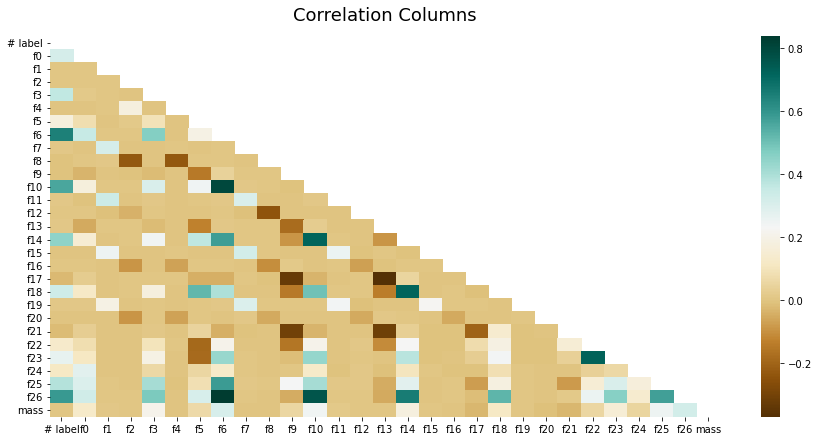

In [10]:
corr_map(DATA, 15,7)


In [11]:
to_drop = auto_corr(DATA, 0.9)

There are no variables correlated over 0.9


## <font color='blue'>Modeling Preparations (10pts)</font>
The data analytics team speficially has a request to utilize a neural network to conduct binary classification that determines the existence of a new particle from the client's experiments. However, to understand whether the model is working and have something to compare against, we will also implement a simple RandomForest model. RandomForest classifications are know for having excellent permormance with little tuning, especially on a large dataset like ours, with an even distribution of the target variable. Accuracy will be the main metric utilized to determine how well the model fits and predicts the data using an 80/20 hold-out validation set. Precision and recall along with a confusion matrix will also be utilized to ensure the accuracy isn't erroneously ignoring one class or the other, but since the data is balanced that should be less of an issue. 


## <font color='blue'> Model Building and Evaluation (60pts)</font>
We will first run our models on a small 1% subsample of the data to adjust parameters quickly. Then we will use the full data set. The analysis section will follow the models. 

**Train/Test Split on Subsample**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# train_test_split function

def xy_split(DATA):
  X = DATA.drop(columns=['# label'], axis = 1)
  y = DATA['# label']
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  #scale the data
  sc = StandardScaler()

  x_train = sc.fit_transform(x_train)
  x_test = sc.transform(x_test)
  return x_train, x_test, y_train, y_test

  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [13]:
# sampled data
x_train, x_test, y_train, y_test = xy_split(DATA)

**RANDOM FOREST MODEL - Subsample**<br>
Based on 1% subsample of data

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


rf = RandomForestClassifier(n_estimators = 10, max_depth= 5, class_weight = 'balanced_subsample', random_state=42)
rf.fit(x_train, y_train)

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
y_hat = rf.predict(x_train)

acc =  accuracy_score(y_hat, y_train)
cm = confusion_matrix(y_train, y_hat)

In [16]:
print("Accuracy: ", acc)
print("Confusion Matrix:")
print(cm)

Accuracy:  0.82575
Confusion Matrix:
[[24492  3623]
 [ 6135 21750]]


**NEURAL NETWORK MODEL - Subsample** <br>
Based on 1% subsample of data

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# build the neural network
# https://www.tensorflow.org/api_docs/python/tf/keras/Model

def nn_model(x_train,y_train):
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=(28,))) #input layer
  model.add(tf.keras.layers.Dense(256, activation = 'relu')) # hidden layer, 28 neurons
  model.add(tf.keras.layers.Dense(32, activation = 'relu'))
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

  model.compile(loss = 'BinaryCrossentropy', optimizer = 'adam', metrics=[tf.keras.metrics.BinaryAccuracy()])

  early_stopping = EarlyStopping(monitor = 'val_loss',
                                min_delta = 0.001,
                                patience = 2)

  history = model.fit(x_train, y_train,
          validation_split = 0.2,
          epochs = 100,
          batch_size = 10000,
          verbose = 1, # 0 = silent, 1 = status bar, 2 = line by line
          callbacks = early_stopping)
  return model, history


In [19]:
# plotting function for Loss and Accuracy, adapted from Machine Learning II class code

def plot_training_curves(history, title=None):
  '''plot the training curves for loss and accuracy given a model history'''

  # find the min loss epoch
  minimum = np.min(history.history['val_loss'])
  min_loc = np.where(minimum == history.history['val_loss'])[0]

  # get the vline y-min and y-max
  loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                        max(history.history['val_loss'] + history.history['loss']))
  acc_min, acc_max = (min(history.history['val_binary_accuracy'] + history.history['binary_accuracy']),
                        max(history.history['val_binary_accuracy'] + history.history['binary_accuracy']))
  
  # create figure
  fig, ax = plt.subplots(ncols = 2, figsize = (15,10))
  fig.suptitle(title)
  idx = np.arange(1, len(history.history['binary_accuracy']) + 1 )

  # plot loss && validation loss
  ax[0].plot(idx, history.history['loss'], label = 'loss')
  ax[0].plot(idx, history.history['val_loss'], label = 'val_loss')
  ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
  ax[0].set_title('Loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].legend()

  # plot accuracy && validation accuracy
  ax[1].plot(idx, history.history['binary_accuracy'], label = 'binary_accuracy')
  ax[1].plot(idx, history.history['val_binary_accuracy'], label = 'val_binary_accuracy')
  ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
  ax[1].set_title('Binary_Accuracy')
  ax[1].set_ylabel('Binary_Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].legend()
  plt.show()

Epoch 1/100
5/5 [==============================] - 3s 65ms/step - loss: 0.6179 - binary_accuracy: 0.6579 - val_loss: 0.5232 - val_binary_accuracy: 0.7866
Epoch 2/100
5/5 [==============================] - 0s 13ms/step - loss: 0.4990 - binary_accuracy: 0.7850 - val_loss: 0.4474 - val_binary_accuracy: 0.8064
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.4431 - binary_accuracy: 0.7995 - val_loss: 0.4114 - val_binary_accuracy: 0.8146
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4148 - binary_accuracy: 0.8094 - val_loss: 0.3899 - val_binary_accuracy: 0.8257
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.3938 - binary_accuracy: 0.8177 - val_loss: 0.3721 - val_binary_accuracy: 0.8326
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.3758 - binary_accuracy: 0.8254 - val_loss: 0.3598 - val_binary_accuracy: 0.8363
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.36

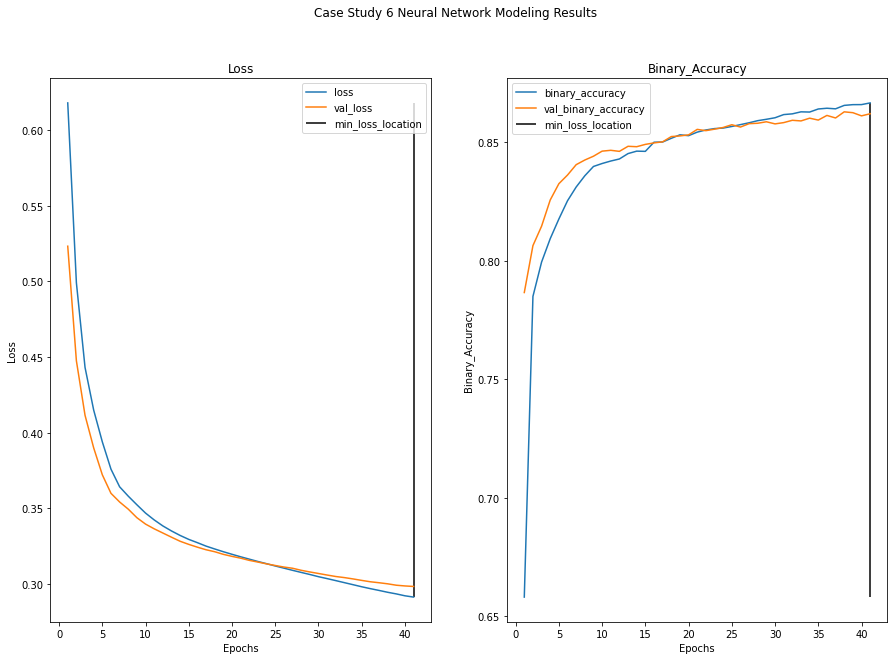

In [20]:
# build the neural network
# use BinaryAccuracy as the metric from the tensorflow library functions: 
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy

model, history = nn_model(x_train, y_train)
preds = model.predict(x_test)
preds = np.round(preds) # we can adjust this to increase recall and precision since we are estimating probabilities

print('\n\n\n', pd.DataFrame(confusion_matrix(y_test, np.round(preds),labels = [0,1]),
             columns = ['None','New Particle'],
             index = ['None', 'New Particle']))

print('\naccuracy: %0.2f ' % accuracy_score(y_test, np.round(preds)))
print('\nprecision: %0.2f ' % precision_score(y_test, np.round(preds)))
print('\nrecall: %0.2f ' % recall_score(y_test, np.round(preds)))

print('\n\n')
plot_training_curves(history, title = 'Case Study 6 Neural Network Modeling Results')

In [21]:
#pd.DataFrame(preds)[0].unique()

**Train/Test Split on full dataset**

In [22]:
# all data
x_train, x_test, y_train, y_test = xy_split(init_df)


**RandomForest Classifier - All Data**

In [23]:
rf = RandomForestClassifier(n_estimators = 10, max_depth= 5, class_weight = 'balanced_subsample', random_state=42)
rf.fit(x_train, y_train)

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [24]:
y_hat_train = rf.predict(x_train)

acc_train =  accuracy_score(y_hat_train, y_train)
cm_train = confusion_matrix(y_train, y_hat_train)

In [25]:
print("Train Accuracy: ", acc_train)
print("Train Confusion Matrix:")
print(cm_train)

Train Accuracy:  0.8248464285714285
Train Confusion Matrix:
[[2409919  390051]
 [ 590809 2209221]]


In [26]:
y_hat_test = rf.predict(x_test)

acc_test =  accuracy_score(y_hat_test, y_test)
cm_test = confusion_matrix(y_test, y_hat_test)

In [27]:
print("Test Accuracy: ", acc_test)
print("Test Confusion Matrix:")
print(cm_test)

Test Accuracy:  0.8248314285714285
Test Confusion Matrix:
[[601873  97278]
 [147958 552891]]


**Neural Network - All Data**

Epoch 1/100
448/448 [==============================] - 4s 8ms/step - loss: 0.3186 - binary_accuracy: 0.8516 - val_loss: 0.2879 - val_binary_accuracy: 0.8657
Epoch 2/100
448/448 [==============================] - 4s 8ms/step - loss: 0.2833 - binary_accuracy: 0.8691 - val_loss: 0.2799 - val_binary_accuracy: 0.8716
Epoch 3/100
448/448 [==============================] - 4s 8ms/step - loss: 0.2768 - binary_accuracy: 0.8734 - val_loss: 0.2749 - val_binary_accuracy: 0.8748
Epoch 4/100
448/448 [==============================] - 3s 7ms/step - loss: 0.2729 - binary_accuracy: 0.8759 - val_loss: 0.2720 - val_binary_accuracy: 0.8767
Epoch 5/100
448/448 [==============================] - 3s 8ms/step - loss: 0.2701 - binary_accuracy: 0.8776 - val_loss: 0.2701 - val_binary_accuracy: 0.8778
Epoch 6/100
448/448 [==============================] - 3s 7ms/step - loss: 0.2684 - binary_accuracy: 0.8786 - val_loss: 0.2689 - val_binary_accuracy: 0.8783
Epoch 7/100
448/448 [==============================] - 3s 

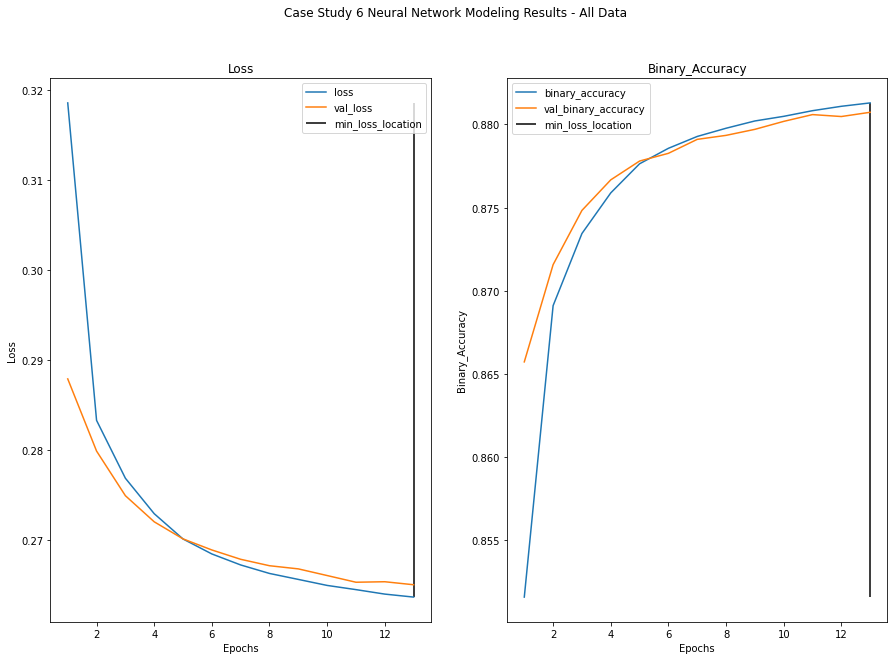

In [28]:
model, history = nn_model(x_train, y_train)
preds = model.predict(x_test)
preds = np.round(preds) # we can adjust this to increase recall and precision since we are estimating probabilities

print('\n\n\n', pd.DataFrame(confusion_matrix(y_test, np.round(preds),labels = [0,1]),
             columns = ['None','New Particle'],
             index = ['None', 'New Particle']))

print('\naccuracy: %0.2f ' % accuracy_score(y_test, np.round(preds)))
print('\nprecision: %0.2f ' % precision_score(y_test, np.round(preds)))
print('\nrecall: %0.2f ' % recall_score(y_test, np.round(preds)))

print('\n\n')
plot_training_curves(history, title = 'Case Study 6 Neural Network Modeling Results - All Data')

## Analysis

We began by running a small sample of 1% of the data in order to quickly adjust parameters in a reasonable amount of time. Using the gpu provided by Google Colab allowed for almost instant results for the neural network subset, and a manageable run time for the full dataset and random forest models. For the purpose of this study, we will only discuss the results from the full models.

Just a note- our RandomForest model was straightforward and limited to reduce run time. It might be possible that if allowed to run a bigger tree, the model would have hit a similar level of accuracy as the simple neural network, but the trade off in time compared to how quickly the neural network was able to run was not worth it.

We ran a RandomForest Classifier that resulted in an accuracy of 82.5%. The test set consisted of 1,400,000 records, and 699,151 of those were classified correctly, with a fairly high precision and recall, which makes sense because the classifications were balanced. 
The neural network with 2 dense layers plus a binary output layer resulted in an accuracy of 88%, which was a 5.5% improvement on the RandomForest model. Of 1,400,000 records, 1,232,523 were classified correctly. 

For the neural network, we visualized the accuracy against the validation accuracy to ensure the model was not over or underfit. The chart shows no major descrepancies between the training and validation, so there is little concern for overfitting. This makes sense because we only used two layers for our neural network, which is considered very basic. Our model could probably benefit from added complexity in the form of additional layers, but we would need to keep an eye on this chart to ensure the model didn't become overfit from the additional layers. 


## <font color='blue'> Case Conclusions (10pts) </font>
The neural network does see a significant improvement on performance over a standard RandomForest model. Although the accuracy was fairly high (88%), the dataset is so large, the model still results in over 160k misclassified data points. Without domain knowledge, we are not sure if that is a manageable number of misclassifications, considering the dataset had 7 million records to start with.

To better quantify what this means: for about every 6 records where nothing was detected and no new particle was present, there was one record where a new particle was present but not detected. In other words, about 1 in 6 new particles are not detected under this model. 

On the flip side, for every 10 records where a new particle was detected correctly, there was 1 record where the particle was not present but was misclassified as detected.

In order to reduce errors and improve the accuracy of the neural network, we would likely need to add complexity by adding layers. This is not a problem from an interpretability standpoint, since that is not the primary concern here. The main drawback would come in the form of processing power and run time. 

It is up to the client to determine if the added cost of processing power and/or increased run time of the model is worth the trade off to improve accuracy in the model. Due to the size of the data, it's likely that even small gains in accuracy could improve cost savings and produtivity in a big way. To determine if this is viable, it would be a simple matter to add an additional layer to neural network and run it on the small subset of data. Since the accuracy of that subsection was comparable to the accuracy of the same model on the bigger data set, we could quickly see how much improvement in accuracy would come from adding a little complexity to the model. 